SparkSession 생성

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ChurnEDA") \
    .getOrCreate()

spark

CSV 데이터 로딩

## 데이터 불러오기
`Telco Customer Churn` 데이터를 PySpark로 불러온다. 헤더가 있는 CSV 파일이며, inferSchema 옵션을 통해 자동으로 타입을 추론한다.

In [2]:
df = spark.read.csv("../data/Telco_customer_churn.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- churn_rate: integer (nullable = true)
 |-- Churn Score: integer (nullable = t

이탈 여부(Churn) 분포 확인

## 이탈 여부(Churn) 분포 확인
데이터셋의 타겟 컬럼인 `Churn`의 값 분포를 확인한다. 클래스 불균형 여부를 파악하는 데 유용하다.

In [3]:
df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



컬럼 이름 리스트 출력

In [4]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'churn_rate',
 'Churn Score',
 'CLTV',
 'Churn Reason',
 'Count',
 'Country',
 'State',
 'City',
 'Zip Code',
 'Lat Long',
 'Latitude',
 'Longitude',
 'Age',
 'Under 30',
 'Married',
 'Referred a Friend',
 'Number of Referrals',
 'Offer',
 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download',
 'Streaming Music',
 'Premium Tech Support',
 'Unlimited Data',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue',
 'Satisfaction Score',
 'Customer Status',
 'Churn Score.1',
 'Churn Category']

컬럼 이름 정제 (공백, 마침표 → 언더스코어)

In [5]:
for old_name in df.columns:
    new_name = old_name.strip().replace(" ", "_").replace(".", "_")
    if old_name != new_name:
        df = df.withColumnRenamed(old_name, new_name)
df.columns
df.describe().show()

+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+------------------+------------------+------------------+--------------------+-----+-------------+----------+------+------------------+--------------------+-----------------+------------------+-----------------+--------+-------+-----------------+-------------------+-------+---------------------------------+-----------------------+---------------+--------------------+--------------+------------------+------------------------+---------------------------+------------------+------------------+---------------+------------------+--------------+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|Onli

결측치 확인

In [6]:
from pyspark.sql.functions import col, count, isnan, when

df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+----------+-----------+----+------------+-----+-------+-----+----+--------+--------+--------+---------+---+--------+-------+-----------------+-------------------+-----+---------------------------------+-----------------------+---------------+--------------------+--------------+-------------+------------------------+---------------------------+-------------+------------------+---------------+-------------+--------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|churn_rate|Churn_Score|CLTV|Churn_Reason|Count|Country

TotalCharges에 빈 문자열 있는지 확인

In [7]:
df.filter(col("TotalCharges") == "").show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+----------+-----------+----+------------+-----+-------+-----+----+--------+--------+--------+---------+---+--------+-------+-----------------+-------------------+-----+---------------------------------+-----------------------+---------------+--------------------+--------------+-------------+------------------------+---------------------------+-------------+------------------+---------------+-------------+--------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|churn_rate|Churn_Score|CLTV|Churn_Reason|Count|Country

In [8]:
from pyspark.sql.functions import col

df = df.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [9]:
df.groupBy("Churn").avg("MonthlyCharges", "tenure", "TotalCharges").show()

+-----+-------------------+------------------+------------------+
|Churn|avg(MonthlyCharges)|       avg(tenure)| avg(TotalCharges)|
+-----+-------------------+------------------+------------------+
|   No|   61.2651236953999| 37.56996521066873|2555.3441410032997|
|  Yes|   74.4413322632423|17.979133226324237|1531.7960941680035|
+-----+-------------------+------------------+------------------+



In [10]:
df.groupBy("Contract", "Churn").count().orderBy("Contract", "Churn").show()

+--------------+-----+-----+
|      Contract|Churn|count|
+--------------+-----+-----+
|Month-to-month|   No| 2220|
|Month-to-month|  Yes| 1655|
|      One year|   No| 1307|
|      One year|  Yes|  166|
|      Two year|   No| 1647|
|      Two year|  Yes|   48|
+--------------+-----+-----+



In [11]:
df.groupBy("InternetService", "Churn").count().orderBy("InternetService", "Churn").show()

+---------------+-----+-----+
|InternetService|Churn|count|
+---------------+-----+-----+
|            DSL|   No| 1962|
|            DSL|  Yes|  459|
|    Fiber optic|   No| 1799|
|    Fiber optic|  Yes| 1297|
|             No|   No| 1413|
|             No|  Yes|  113|
+---------------+-----+-----+



In [12]:
categorical_cols = [
    "Contract",
    "InternetService",
    "PaymentMethod",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "MultipleLines",
    "PhoneService",
    "PaperlessBilling",
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents"
]

## 범주형 변수별 이탈률 확인
`show_churn_rate_by` 함수를 사용하여 각 범주형 변수에 따라 Churn 여부가 어떻게 분포하는지 확인한다. 이탈률이 높거나 낮은 특정 그룹이 존재하는지 파악할 수 있다.

In [13]:
from pyspark.sql.functions import col, round

def show_churn_rate_by(column_name):
    total = df.groupBy(column_name).count().withColumnRenamed("count", "total")
    churned = df.filter(col("Churn") == "Yes") \
                .groupBy(column_name).count().withColumnRenamed("count", "churned")
    
    joined = total.join(churned, column_name, "left").fillna(0)
    result = joined.withColumn(
        "churn_rate(%)", round(col("churned") / col("total") * 100, 2)
    ).orderBy("churn_rate(%)", ascending=False)
    
    result.select(column_name, "total", "churned", "churn_rate(%)").show(truncate=False)

## 범주형 변수별 이탈률 확인
`show_churn_rate_by` 함수를 사용하여 각 범주형 변수에 따라 Churn 여부가 어떻게 분포하는지 확인한다. 이탈률이 높거나 낮은 특정 그룹이 존재하는지 파악할 수 있다.

In [14]:
show_churn_rate_by("PaymentMethod")
show_churn_rate_by("TechSupport")
show_churn_rate_by("OnlineSecurity")

+-------------------------+-----+-------+-------------+
|PaymentMethod            |total|churned|churn_rate(%)|
+-------------------------+-----+-------+-------------+
|Electronic check         |2365 |1071   |45.29        |
|Mailed check             |1612 |308    |19.11        |
|Bank transfer (automatic)|1544 |258    |16.71        |
|Credit card (automatic)  |1522 |232    |15.24        |
+-------------------------+-----+-------+-------------+

+-------------------+-----+-------+-------------+
|TechSupport        |total|churned|churn_rate(%)|
+-------------------+-----+-------+-------------+
|No                 |3473 |1446   |41.64        |
|Yes                |2044 |310    |15.17        |
|No internet service|1526 |113    |7.4          |
+-------------------+-----+-------+-------------+

+-------------------+-----+-------+-------------+
|OnlineSecurity     |total|churned|churn_rate(%)|
+-------------------+-----+-------+-------------+
|No                 |3498 |1461   |41.77        |


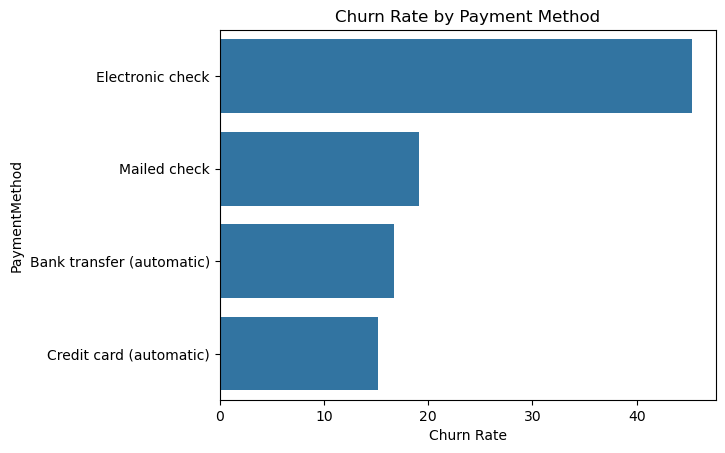

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'PaymentMethod': ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
    'Churn Rate': [45.29, 19.11, 16.71, 15.24]
}

df_plot = pd.DataFrame(data)
sns.barplot(x='Churn Rate', y='PaymentMethod', data=df_plot)
plt.title('Churn Rate by Payment Method')
plt.show()

## 라벨 인코딩
`Churn` 컬럼의 문자열 값을 모델 학습에 사용할 수 있도록 0 또는 1의 수치형 라벨로 변환한다. PySpark의 `StringIndexer`를 사용하며, 변환된 컬럼 이름은 `label`이다.

In [16]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(inputCol="Churn", outputCol="label")
df_ml = label_indexer.fit(df).transform(df)
df_ml.select("Churn", "label").show(5)

+-----+-----+
|Churn|label|
+-----+-----+
|  Yes|  1.0|
|  Yes|  1.0|
|  Yes|  1.0|
|  Yes|  1.0|
|  Yes|  1.0|
+-----+-----+
only showing top 5 rows



In [17]:
categorical_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

## 범주형 변수 인코딩
모델 학습을 위해 모든 범주형 컬럼을 수치형으로 변환한다. 각 컬럼마다 `_index` 접미사가 붙은 새로운 컬럼이 생성된다. `Pipeline`을 사용하여 여러 개의 `StringIndexer`를 순차적으로 적용한다.

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index")
    for col in categorical_cols
]

In [19]:
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df_ml).transform(df_ml)

In [20]:
df_indexed.select("Contract", "Contract_index", "PaymentMethod", "PaymentMethod_index").show(5)

+--------------+--------------+--------------------+-------------------+
|      Contract|Contract_index|       PaymentMethod|PaymentMethod_index|
+--------------+--------------+--------------------+-------------------+
|Month-to-month|           0.0|        Mailed check|                1.0|
|Month-to-month|           0.0|    Electronic check|                0.0|
|Month-to-month|           0.0|    Electronic check|                0.0|
|Month-to-month|           0.0|    Electronic check|                0.0|
|Month-to-month|           0.0|Bank transfer (au...|                2.0|
+--------------+--------------+--------------------+-------------------+
only showing top 5 rows



## 특징 벡터 생성
모델에 입력할 모든 feature를 하나의 벡터 컬럼으로 합친다. `VectorAssembler`를 사용하여 인코딩된 범주형 변수와 수치형 변수를 결합하고, 새로운 컬럼 `features`를 생성한다.

In [21]:
from pyspark.ml.feature import VectorAssembler

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
input_features = [f"{col}_index" for col in categorical_cols] + numeric_cols

assembler = VectorAssembler(
    inputCols=input_features,
    outputCol="features"
)

df_final = assembler.transform(df_indexed)
df_final.select("features", "label").show(truncate=False)

+-------------------------------------------------------------------------------------+-----+
|features                                                                             |label|
+-------------------------------------------------------------------------------------+-----+
|(19,[6,7,8,15,16,17,18],[1.0,1.0,1.0,1.0,2.0,53.85,108.15])                          |1.0  |
|(19,[0,16,17,18],[1.0,2.0,70.7,151.65])                                              |1.0  |
|(19,[0,5,9,11,12,16,17,18],[1.0,1.0,1.0,1.0,1.0,8.0,99.65,820.5])                    |1.0  |
|(19,[0,2,5,9,10,11,12,16,17,18],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,104.8,3046.05])    |1.0  |
|(19,[5,8,9,11,12,15,16,17,18],[1.0,1.0,1.0,1.0,1.0,2.0,49.0,103.7,5036.3])           |1.0  |
|(19,[0,2,3,6,9,10,14,15,16,17,18],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,10.0,55.2,528.35])|1.0  |
|(19,[1,4,5,6,9,12,16,17,18],[1.0,1.0,2.0,1.0,1.0,1.0,1.0,39.65,39.65])               |1.0  |
|[0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.

In [22]:
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

In [23]:
df_final_clean = df_final.na.drop()
train_data, test_data = df_final_clean.randomSplit([0.8, 0.2], seed=42)

In [24]:
# 1. 실제 모델 학습에 쓰이는 컬럼 전체 확인
all_required_cols = input_features + ["label"]

# 2. 이 컬럼들 중에 null 있는 행을 제거
df_clean = df_final.select(all_required_cols).na.drop()

# 3. 다시 학습/검증 데이터셋 나누기
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)


## 특징 벡터 생성
모델에 입력할 모든 feature를 하나의 벡터 컬럼으로 합친다. `VectorAssembler`를 사용하여 인코딩된 범주형 변수와 수치형 변수를 결합하고, 새로운 컬럼 `features`를 생성한다.

In [25]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=input_features,
    outputCol="features",
    handleInvalid="skip"
)

df_clean_with_features = assembler.transform(df_clean)

In [26]:
train_data, test_data = df_clean_with_features.randomSplit([0.8, 0.2], seed=42)

## 로지스틱 회귀 모델 학습
PySpark의 `LogisticRegression`을 사용하여 이진 분류 모델을 학습한다. `features` 벡터와 `label` 컬럼을 기반으로 학습이 수행된다.

In [27]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

In [28]:
print(lr_model.coefficients)
print(lr_model.intercept)

[0.02784971276426697,0.23125465340897627,-0.06636662137802642,-0.10896127357729232,-0.370754402683701,0.34400412650456247,-1.3920944747983632,-0.39304740360929824,-0.05554126486870058,-0.0129843712168413,-0.3794762683229241,0.39230200988510905,0.43784590975101667,-0.3466357063046602,-0.34711537381876584,-0.15608228514422726,-0.06195442356008396,-0.020699721477268236,0.00031667626178437055]
2.4151869139491127


In [29]:
predictions = lr_model.transform(test_data)
predictions.select("label", "prediction", "probability").show(10, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1.0  |1.0       |[0.2809673483585061,0.7190326516414939] |
|1.0  |1.0       |[0.2828241110119512,0.7171758889880488] |
|0.0  |1.0       |[0.2832377327169767,0.7167622672830233] |
|0.0  |1.0       |[0.2851035499875372,0.7148964500124628] |
|1.0  |1.0       |[0.31769123507266217,0.6823087649273378]|
|1.0  |1.0       |[0.35870192606958423,0.6412980739304157]|
|0.0  |1.0       |[0.3322071279322613,0.6677928720677386] |
|1.0  |1.0       |[0.39631410146961626,0.6036858985303837]|
|1.0  |1.0       |[0.39867432057661784,0.6013256794233821]|
|0.0  |1.0       |[0.40962285948344623,0.5903771405165538]|
+-----+----------+----------------------------------------+
only showing top 10 rows



## 모델 성능 평가
테스트 데이터에 대한 예측 결과를 바탕으로 ROC AUC 점수를 계산한다. 이 점수는 모델의 분류 성능을 나타내며, 1에 가까울수록 성능이 좋음을 의미한다.

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"📈 ROC AUC Score: {auc:.4f}")

📈 ROC AUC Score: 0.8426


In [ ]:
# lr_model.save("churn_logistic_model")